In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [32]:
data = pd.read_csv('processed_train.csv')
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Разобьем выборку на тест и трейн

In [33]:
from sklearn.model_selection import train_test_split

X = data.drop('HasDetections', axis=1)
y = data['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=33)

Обучите LogReg и SVM с помощью классов `LogisticRegression` и `LinearSVC`. Добавьте шаг стандартизации данных в пайплайны. Для разнообразия, возьмем `MinMaxScaler`. Пайплайны запишем в переменные `pipe_lr` и `pipe_svm` соответственно!

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

### Your code is here
pipe_lr = Pipeline([('MinMaxScaler', MinMaxScaler()), ('LogisticRegression', LogisticRegression())])

pipe_svm = Pipeline([('MinMaxScaler', MinMaxScaler()), ('LinearSVC', LinearSVC())])

In [35]:
### Обучаем модели на трейне
### Your code is here

pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                ('LogisticRegression', LogisticRegression())])

In [36]:
pipe_svm.fit(X_train, y_train)

Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), ('LinearSVC', LinearSVC())])

In [37]:
pipe_lr.score(X_test, y_test)

0.8428994206160644

In [38]:
pipe_svm.score(X_test, y_test)

0.84039848276437

Постройте ROC для обеих моделей, посчитайте AUC . Конечно же, обучение проводите на трейне, а замеры - на тесте.

Заметьте! Классическая реализация `SVM`, как и в лекциях, не дает никакой оценки вероятности. Чтобы трансформировать выходы в вероятности, на практике мы использовали функцию-сигмоиду. Здесь предлагаем Вам трансформировать выходы `decision_function` в вероятности пропорциональным способом.

Например, вы обучили `SVM`, и на тестовых данных модель выдала следующие выходы `decision_function`:

(-10, -5, 0, +2, +10, +15)

Для каждого числа необходимо сделать преобразование в выражение вида `P(y = +1 | x)`.

С одной стороны, отрицательный знак числа будет сигнализировать нам о том, что `P(y = +1 | x) < 0.5`.

Тогда положительный о том, что `P(y = +1 | x) > 0.5`. 

С другой стороны, для тех объектов, в которых модель уверена больше всего, положим краевые вероятности. Для примера выше:

`P(y = +1 | -10) = 0`, `P(y = +1 | +15) = 1`. Для всех промежуточных объектов применим пропорциональное преобразование. Например:

$$
P(y = +1 | -5) = \frac{|-5-(-10)|}{|-10|} \cdot 0.5
$$

$$
P(y = +1 | +2) = \frac{|+2|}{|+15|} \cdot 0.5 + 0.5
$$
Таким образом мы можем перевести выходы SVM в отрезок [0;1] и попробовать интерпретировать новые числа как вероятности, чтобы изобразить калибровочную кривую. При таком преобразовании пропорции внутри первоначально отрицательных и внутри положительных чисел сохраняются.

In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

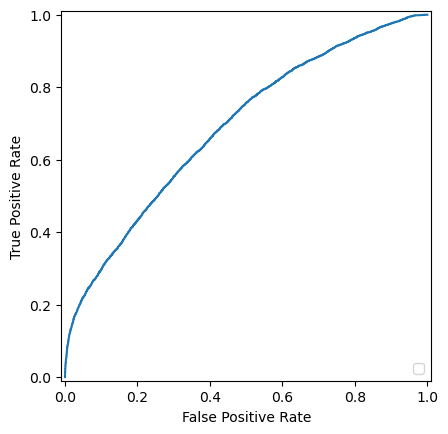

In [42]:
### С изображением рок-кривой для ЛогРега не будет проблем:
### Your code is here
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, pipe_lr.predict_proba(X_test)[:, 1])

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay(fpr=fpr_lr, tpr=tpr_lr).plot()

In [43]:
### А для того, чтобы построить и изобразить рок-кривую для SVM, придется
### в начале преобразовать выходы pipe_svm.decision_function

### Your code is here
pipe_svm.decision_function(X_test)

array([-0.55390637, -0.6714675 , -0.74586792, ..., -0.76625053,
       -0.60052473, -0.77888725])

In [45]:
def svm_decision_to_proba(decision_scores):
    """
    Преобразует выходы decision_function SVM в вероятности
    с использованием пропорционального преобразования
    """
    probas = np.zeros_like(decision_scores, dtype=float)
    
    # Разделяем на отрицательные и положительные значения
    neg_scores = decision_scores[decision_scores < 0]
    pos_scores = decision_scores[decision_scores >= 0]
    
    # Обрабатываем отрицательные значения
    if len(neg_scores) > 0:
        min_neg = np.min(neg_scores)
        max_neg = np.max(neg_scores)
        
        if min_neg == max_neg:
            # Все отрицательные значения одинаковы
            neg_probas = np.full_like(neg_scores, 0.0)
        else:
            # Пропорциональное преобразование для отрицательных значений
            neg_probas = 0.5 * (neg_scores - min_neg) / (max_neg - min_neg)
            neg_probas = np.clip(neg_probas, 0, 0.5)
    
    # Обрабатываем положительные значения
    if len(pos_scores) > 0:
        min_pos = np.min(pos_scores)
        max_pos = np.max(pos_scores)
        
        if min_pos == max_pos:
            # Все положительные значения одинаковы
            pos_probas = np.full_like(pos_scores, 1.0)
        else:
            # Пропорциональное преобразование для положительных значений
            pos_probas = 0.5 + 0.5 * (pos_scores - min_pos) / (max_pos - min_pos)
            pos_probas = np.clip(pos_probas, 0.5, 1.0)
    
    # Собираем вероятности обратно в исходный порядок
    neg_mask = decision_scores < 0
    pos_mask = decision_scores >= 0
    
    if len(neg_scores) > 0:
        probas[neg_mask] = neg_probas
    if len(pos_scores) > 0:
        probas[pos_mask] = pos_probas
    
    return probas
    
pred_prob = svm_decision_to_proba(pipe_svm.decision_function(X_test))
pred_prob

array([0.34276055, 0.30936853, 0.28823587, ..., 0.2824464 , 0.32951909,
       0.27885707])

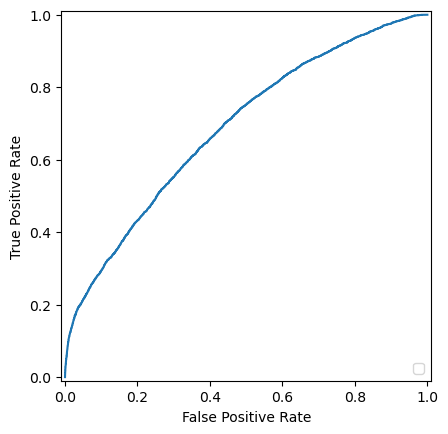

In [46]:
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, pred_prob)

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay(fpr=fpr_svm, tpr=tpr_svm).plot()

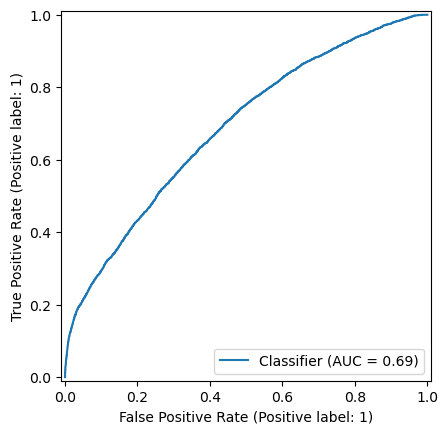

In [47]:
RocCurveDisplay.from_predictions(y_test, pred_prob)

In [48]:
from sklearn.metrics import auc 

### Your code is here
auc(fpr_lr, tpr_lr)

np.float64(0.6889872704410192)

In [49]:
auc(fpr_svm, tpr_svm)

np.float64(0.687808231783975)

In [30]:
auc(fpr_svm, tpr_svm)

np.float64(0.6878082255324112)

Постройте калибровочные кривые для обеих моделей. Методом from_estimator для svm воспользоваться не получится.

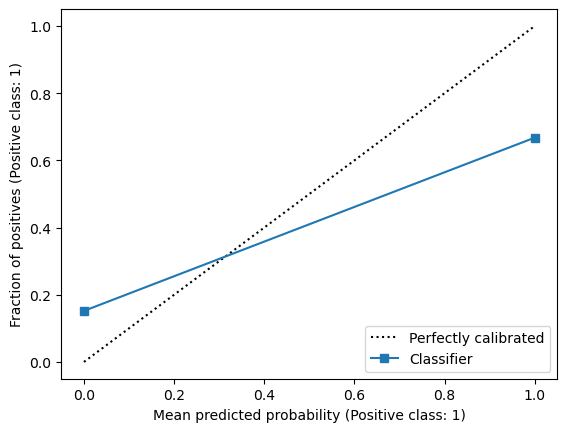

In [54]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


### Your code is here
#для LR
CalibrationDisplay.from_predictions(y_test, pipe_lr.predict(X_test), n_bins=15)

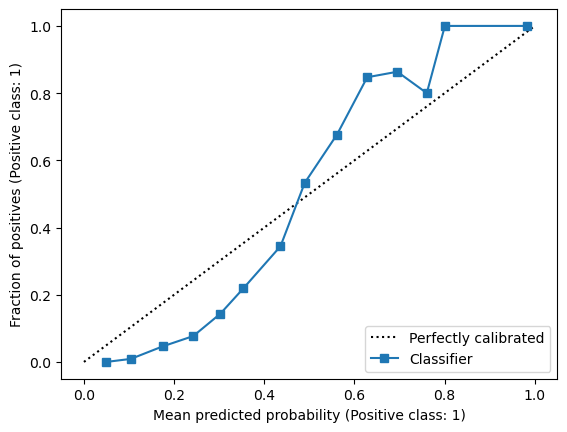

In [51]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay

### Your code is here
#для SVM

CalibrationDisplay.from_predictions(y_test, pred_prob, n_bins=15)

**Какая калибровочная кривая ближе к диагонали?  Откалибруйте SVM способом как в практике и изобразите новую кривую!

In [56]:
### Калибровка

from sklearn.calibration import CalibratedClassifierCV

### Your code is here
### Калибровка Плата

from sklearn.calibration import CalibratedClassifierCV

calibration = CalibratedClassifierCV(pipe_svm, cv=5, method='sigmoid')
calibration.fit(X_train, y_train)

calibrated_probs = calibration.predict_proba(X_test)[:, 1]

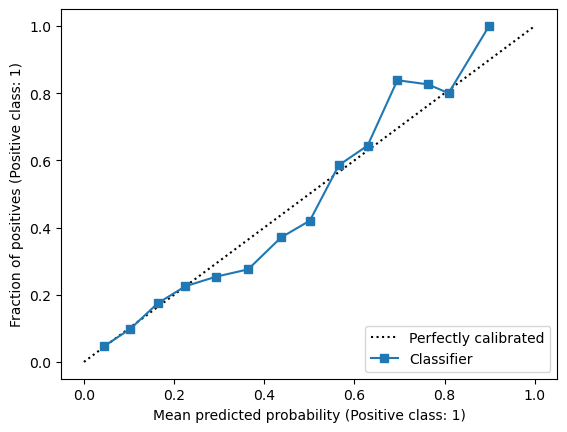

In [58]:
### Новая кривая
### Изображу откалиброванную кривую для SVM алгоритма

CalibrationDisplay.from_predictions(y_test, calibrated_probs, n_bins=15)